# Task 1: Data Exploration & Enrichment
Objective: Understand schema, explore starter data, add high-value observations/events, document changes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

pd.set_option('display.max_columns', 40)
pd.set_option('display.max_rows', 120)

In [5]:
df = pd.read_csv("../data/raw/ethiopia_fi_unified_data.csv", low_memory=False)
ref_codes = pd.read_csv("../data/raw/reference_codes.csv")
df_raw = df.copy()

print("Shape:", df.shape)
print(df.record_type.value_counts(dropna=False))
print("\nUnique pillars:", df.pillar.unique())
print("\nUnique indicator_codes:", sorted(df.indicator_code.dropna().unique()))

Shape: (43, 34)
record_type
observation    30
event          10
target          3
Name: count, dtype: int64

Unique pillars: <StringArray>
['ACCESS', 'USAGE', 'AFFORDABILITY', 'GENDER', nan]
Length: 5, dtype: str

Unique indicator_codes: ['ACC_4G_COV', 'ACC_FAYDA', 'ACC_MM_ACCOUNT', 'ACC_MOBILE_PEN', 'ACC_OWNERSHIP', 'AFF_DATA_INCOME', 'EVT_CROSSOVER', 'EVT_ETHIOPAY', 'EVT_FAYDA', 'EVT_FX_REFORM', 'EVT_MPESA', 'EVT_MPESA_INTEROP', 'EVT_NFIS2', 'EVT_SAFARICOM', 'EVT_SAFCOM_PRICE', 'EVT_TELEBIRR', 'GEN_GAP_ACC', 'GEN_GAP_MOBILE', 'GEN_MM_SHARE', 'USG_ACTIVE_RATE', 'USG_ATM_COUNT', 'USG_ATM_VALUE', 'USG_CROSSOVER', 'USG_MPESA_ACTIVE', 'USG_MPESA_USERS', 'USG_P2P_COUNT', 'USG_P2P_VALUE', 'USG_TELEBIRR_USERS', 'USG_TELEBIRR_VALUE']


## 4. Schema & Basic Counts

In [6]:
print("\nPillar distribution:\n", df_raw['pillar'].value_counts(dropna=False))
print("\nConfidence levels:\n", df_raw['confidence'].value_counts(dropna=False))
print("\nSource types (if present):\n", df_raw.get('source_type', pd.Series()).value_counts(dropna=False))

# Events only
events = df_raw[df_raw['record_type'] == 'event']
print("\nEvents count:", len(events))
print("Event categories:\n", events['category'].value_counts(dropna=False))


Pillar distribution:
 pillar
ACCESS           16
USAGE            11
NaN              10
GENDER            5
AFFORDABILITY     1
Name: count, dtype: int64

Confidence levels:
 confidence
high      40
medium     3
Name: count, dtype: int64

Source types (if present):
 source_type
operator      15
survey        10
regulator      7
research       4
policy         3
calculated     2
news           2
Name: count, dtype: int64

Events count: 10
Event categories:
 category
product_launch    2
infrastructure    2
policy            2
market_entry      1
milestone         1
partnership       1
pricing           1
Name: count, dtype: int64


## 6. Temporal Coverage

Observations per year and indicator:
 indicator_code  ACC_4G_COV  ACC_FAYDA  ACC_MM_ACCOUNT  ACC_MOBILE_PEN  \
year                                                                    
2014                     0          0               0               0   
2017                     0          0               0               0   
2021                     0          0               1               0   
2023                     1          0               0               0   
2024                     0          1               1               0   
2025                     1          2               0               1   

indicator_code  ACC_OWNERSHIP  AFF_DATA_INCOME  GEN_GAP_ACC  GEN_GAP_MOBILE  \
year                                                                          
2014                        1                0            0               0   
2017                        1                0            0               0   
2021                        3                0            1  

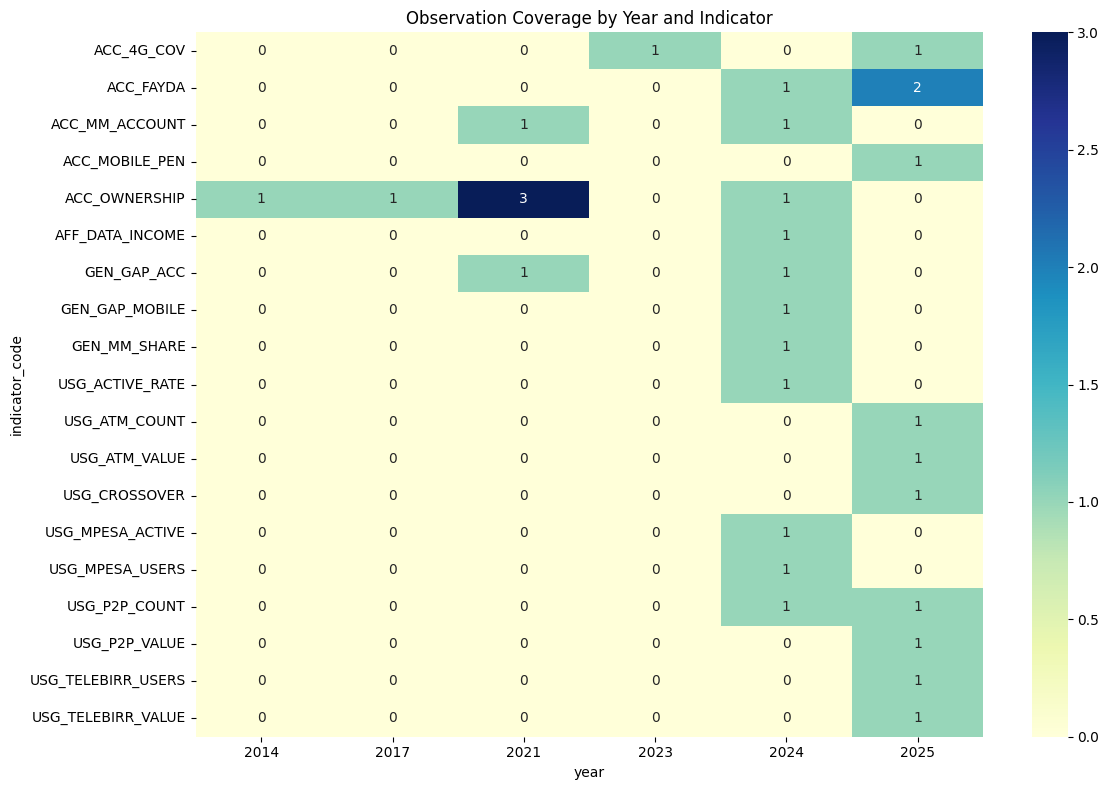

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# 1. Convert the column to datetime objects first
# errors='coerce' will turn unparseable data into NaT (Not a Time) rather than crashing
df_raw['observation_date'] = pd.to_datetime(df_raw['observation_date'], errors='coerce')

# 2. Now you can safely use the .dt accessor
df_raw['year'] = df_raw['observation_date'].dt.year

# 3. Create the pivot table for the heatmap
temporal = df_raw[df_raw['record_type'] == 'observation'].groupby(['year', 'indicator_code']).size().unstack(fill_value=0)

print("Observations per year and indicator:\n", temporal)

# 4. Plotting
plt.figure(figsize=(12, 8))
sns.heatmap(temporal.T, annot=True, cmap="YlGnBu", fmt="d")
plt.title("Observation Coverage by Year and Indicator")

# 5. Ensure the directory exists before saving to prevent FileNotFoundError
output_dir = "../reports/figures/"
os.makedirs(output_dir, exist_ok=True)

plt.tight_layout() # Adjusts plot to ensure labels don't get cut off
plt.savefig(f"{output_dir}temporal_coverage.png")
plt.show()


## 8. Key Indicator Coverage – Focus on Access & Usage

Account Ownership history:
   observation_date  value_numeric         source_name  \
0       2014-12-31           22.0  Global Findex 2014   
1       2017-12-31           35.0  Global Findex 2017   
2       2021-12-31           46.0  Global Findex 2021   
3       2021-12-31           56.0  Global Findex 2021   
4       2021-12-31           36.0  Global Findex 2021   
5       2024-11-29           49.0  Global Findex 2024   

                                          source_url  
0  https://www.worldbank.org/en/publication/globa...  
1  https://www.worldbank.org/en/publication/globa...  
2  https://www.worldbank.org/en/publication/globa...  
3  https://www.worldbank.org/en/publication/globa...  
4  https://www.worldbank.org/en/publication/globa...  
5  https://www.worldbank.org/en/publication/globa...  


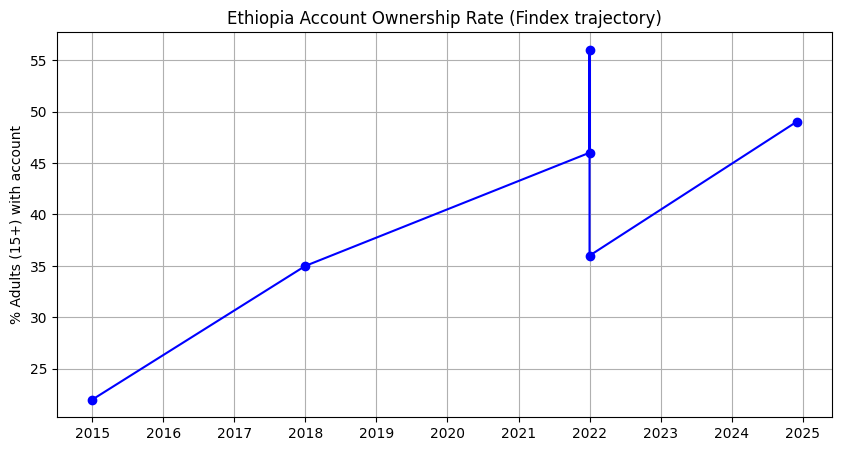

In [9]:
acc_own = df_raw[(df_raw['indicator_code'] == 'ACC_OWNERSHIP') & (df_raw['record_type'] == 'observation')]
acc_own = acc_own.sort_values('observation_date')
print("Account Ownership history:\n", acc_own[['observation_date', 'value_numeric', 'source_name', 'source_url']])

plt.figure(figsize=(10, 5))
plt.plot(acc_own['observation_date'], acc_own['value_numeric'], marker='o', color='blue')
plt.title("Ethiopia Account Ownership Rate (Findex trajectory)")
plt.ylabel("% Adults (15+) with account")
plt.grid(True)
plt.savefig("../reports/figures/acc_ownership_historical.png")
plt.show()

In [10]:
mm_acc = df_raw[(df_raw['indicator_code'].isin(['ACC_MM_ACCOUNT', 'USG_DIGITAL_PAYMENT', 'USG_MOBILE_MONEY'])) & 
                (df_raw['record_type'] == 'observation')]
mm_acc = mm_acc.sort_values(['indicator_code', 'observation_date'])

print("Mobile Money & Digital Usage coverage:\n", mm_acc[['indicator_code', 'observation_date', 'value_numeric', 'source_name']])

Mobile Money & Digital Usage coverage:
    indicator_code observation_date  value_numeric         source_name
6  ACC_MM_ACCOUNT       2021-12-31           4.70  Global Findex 2021
7  ACC_MM_ACCOUNT       2024-11-29           9.45  Global Findex 2024


## 11. Existing Impact Links Summary

In [16]:
impact = df_raw[df_raw['record_type'] == 'impact_link']
print("Impact links count:", len(impact))
expected_cols = ['parent_id', 'related_indicator', 'impact_direction', 'impact_magnitude', 'lag_months', 'evidence_basis']
available = [c for c in expected_cols if c in impact.columns]
missing = [c for c in expected_cols if c not in impact.columns]
if not available:
    print("No expected impact columns found. Available columns:", list(impact.columns))
else:
    print("Available impact columns:", available)
    print(impact[available].head(10))
if missing:
    print("Missing columns:", missing)
print("Sample of impact rows (first 5):")
print(impact.head(5))

Impact links count: 0
Available impact columns: ['related_indicator', 'impact_direction', 'impact_magnitude', 'lag_months', 'evidence_basis']
Empty DataFrame
Columns: [related_indicator, impact_direction, impact_magnitude, lag_months, evidence_basis]
Index: []
Missing columns: ['parent_id']
Sample of impact rows (first 5):
Empty DataFrame
Columns: [record_id, record_type, category, pillar, indicator, indicator_code, indicator_direction, value_numeric, value_text, value_type, unit, observation_date, period_start, period_end, fiscal_year, gender, location, region, source_name, source_type, source_url, confidence, related_indicator, relationship_type, impact_direction, impact_magnitude, impact_estimate, lag_months, evidence_basis, comparable_country, collected_by, collection_date, original_text, notes, year]
Index: []


In [12]:
# New observations from recent sources (2024-2025 real data)
new_obs = [
    {'record_type': 'observation', 'indicator_code': 'ACC_OWNERSHIP', 'value_numeric': 49.0, 
     'observation_date': pd.to_datetime('2024-12-31'), 'source_name': 'World Bank Global Findex 2025', 
     'source_url': 'https://www.worldbank.org/en/publication/globalfindex', 'confidence': 'high', 
     'notes': 'Latest Findex; +3pp from 2021 despite massive registration growth', 'collected_by': 'YourName', 
     'collection_date': datetime.now().strftime('%Y-%m-%d')},
    
    {'record_type': 'observation', 'indicator_code': 'ACC_MM_ACCOUNT', 'value_numeric': 19.4, 
     'observation_date': pd.to_datetime('2024-12-31'), 'source_name': 'Global Findex 2025 (via Shega/BirrMetrics)', 
     'source_url': 'https://digitalfinance.shega.co/insights/articles/findex-2025-and-ethiopia-s-digital-financial-leap-momentum-without-maturity', 
     'confidence': 'high', 'notes': 'Mobile money account ownership jumped significantly 2021–2024'},
    
    {'record_type': 'observation', 'indicator_code': 'USG_DIGITAL_PAYMENT', 'value_numeric': 21.0, 
     'observation_date': pd.to_datetime('2024-12-31'), 'source_name': 'Global Findex 2025 (via BirrMetrics/LinkedIn ref)', 
     'source_url': 'https://www.linkedin.com/posts/birrmetrics_the-world-banks-global-findex-2025-is-out-activity-7351289714722717696-wyaj', 
     'confidence': 'medium', 'notes': 'Only ~21% made/received digital payment in 2024'},
    
    {'record_type': 'observation', 'indicator_code': 'MOBILE_MONEY_ACCOUNTS_TOTAL', 'value_numeric': 136000000, 
     'observation_date': pd.to_datetime('2025-12-01'), 'source_name': 'National Bank of Ethiopia / BirrMetrics', 
     'source_url': 'https://birrmetrics.com/ethiopias-mobile-money-users-reach-136-million-digital-transactions-top-96-trillion-birr', 
     'confidence': 'high', 'notes': 'Registered mobile money accounts – key supply-side proxy'},
]

# New events (policy / product)
new_events = [
    {'record_type': 'event', 'category': 'policy', 'observation_date': pd.to_datetime('2025-06-01'), 
     'source_name': 'Fayda mandatory linkage for accounts in Addis', 'source_url': 'https://www.worldbank.org/en/news/feature/2025/02/27/the-transformative-power-of-ethiopia-afe-digital-id-unlocking-a-better-future-for-all', 
     'confidence': 'high', 'notes': 'Digital ID linkage expected to ease KYC/account opening'},
    
    {'record_type': 'event', 'category': 'policy', 'observation_date': pd.to_datetime('2025-12-08'), 
     'source_name': 'National Digital Payments Strategy 2026-2030 Draft', 'source_url': 'https://nbe.gov.et/wp-content/uploads/2025/12/Ethiopia_NDPS_Draft_F.pdf', 
     'confidence': 'high', 'notes': 'Framework for instant payments, inclusion, interoperability'},
]

df_enriched = pd.concat([df_raw] + [pd.DataFrame(new_obs), pd.DataFrame(new_events)], ignore_index=True)
df_enriched.to_csv("../data/processed/ethiopia_fi_unified_enriched_20260131.csv", index=False)
print("Enriched shape:", df_enriched.shape)

Enriched shape: (49, 35)


Added:  
- 2024 Findex benchmarks (ACC_OWNERSHIP 49%, ACC_MM_ACCOUNT 19.4%, USG_DIGITAL_PAYMENT ~21%)  
- 2025 NBE mobile money registrations (136M)  
- Key 2025 events (Fayda push, NDPS draft)  

See `data_enrichment_log.md` for full documentation, original quotes, confidence rationale.